In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [4]:
pdb='./Villin_Lab/2F4K.protein.pdb'
trajectory='./Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='./Villin_Lab/2f4K.xray.CA.pdb'
outdir='/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)


outdir: /output
pdb: ./Villin_Lab/2F4K.protein.pdb
trjaectory: ./Villin_Lab/2F4K.protein.s10.dcd


In [5]:
stride_sel=5
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [6]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 12559

Starting frame: 0

Last frame: 12559

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [7]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [8]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [9]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


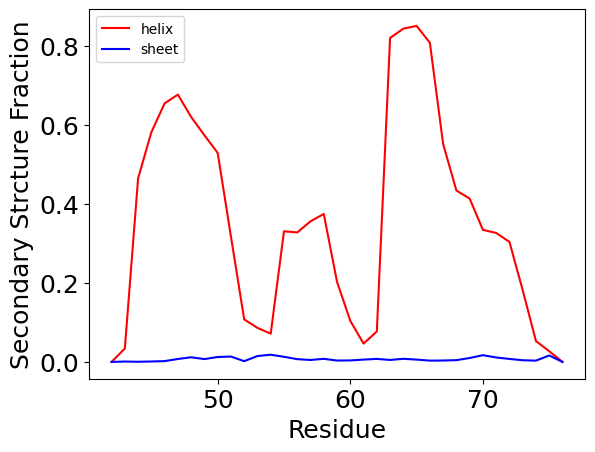

In [10]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [11]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [12]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [13]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




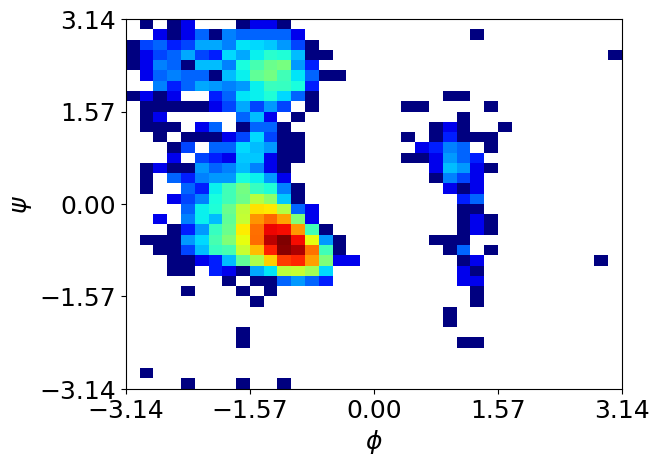

In [14]:
plot_phipsi(66)


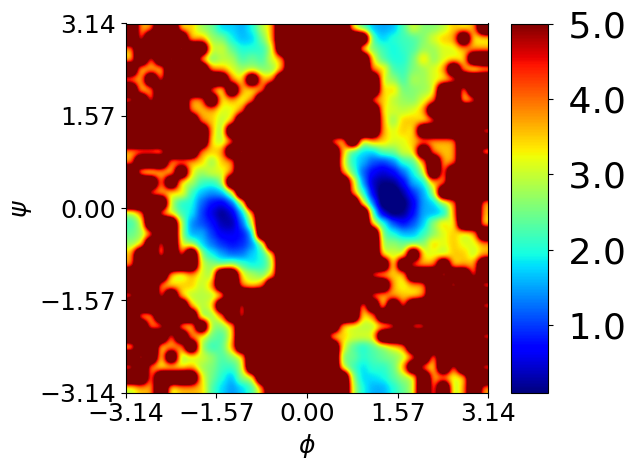

In [15]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(52)

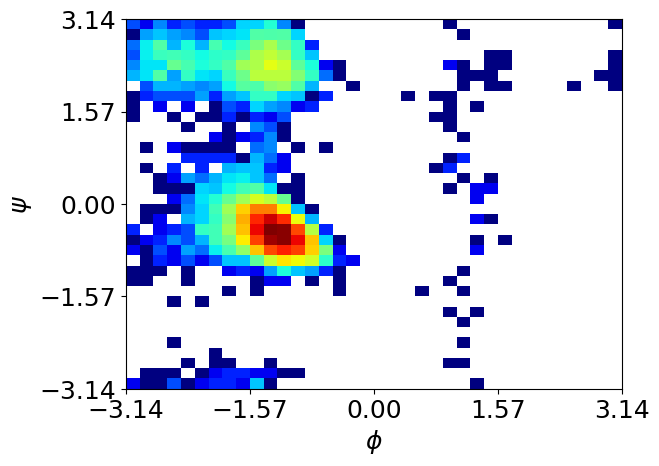

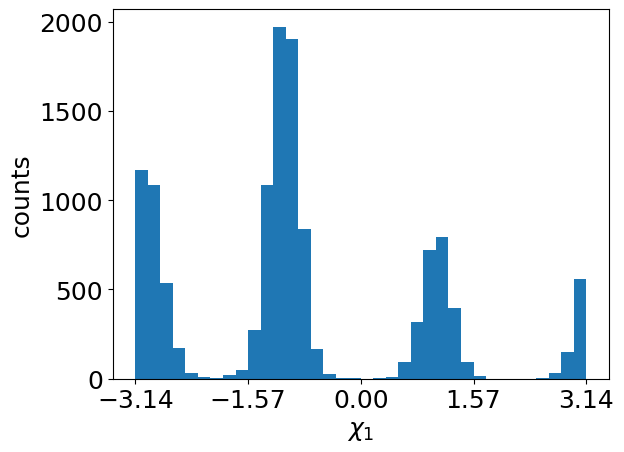

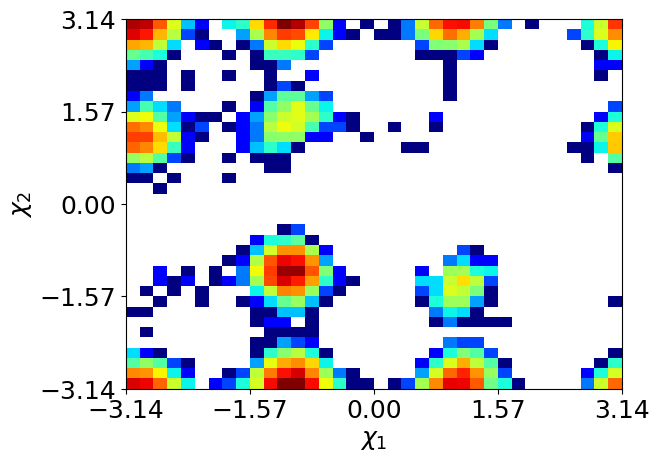

In [16]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [17]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [18]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel) # 
CA=top.select("name CA") # selects only the C alphas
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 12559 frames, 35 atoms, 35 residues, and unitcells at 0x2c37ecea590>

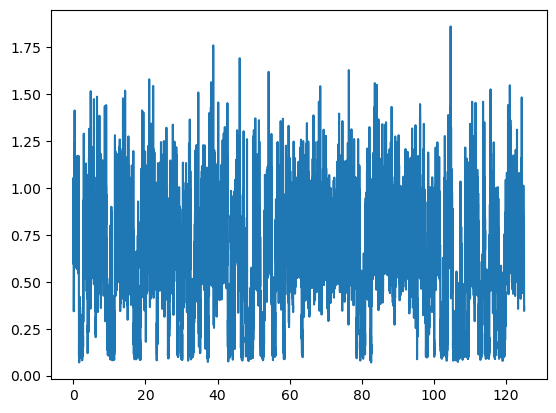

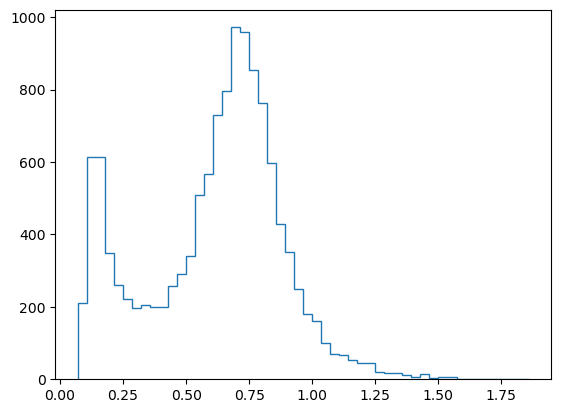

In [19]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

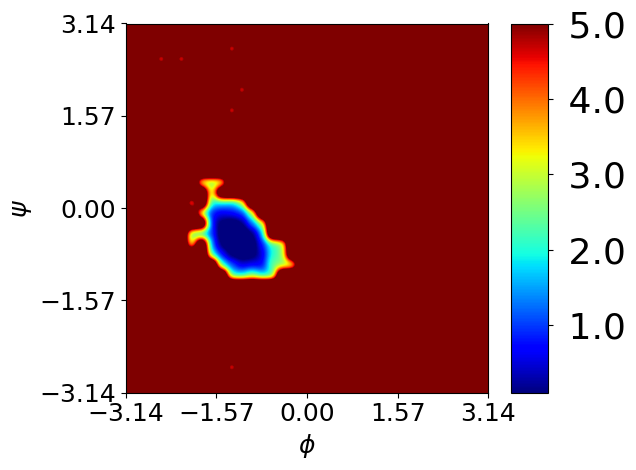

In [20]:
def plot_phipsi_FES_frames(res,frames): # looks at which residue and where they are
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0]
len(native_frames) # 
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(45,native_frames)


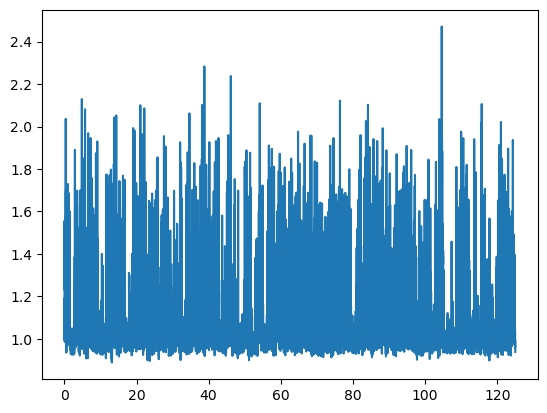

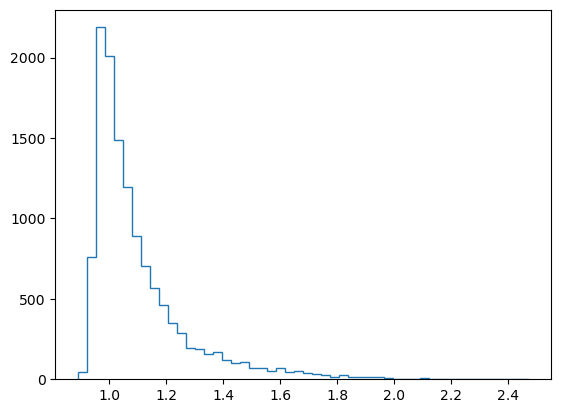

In [21]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [22]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(12559, 2)


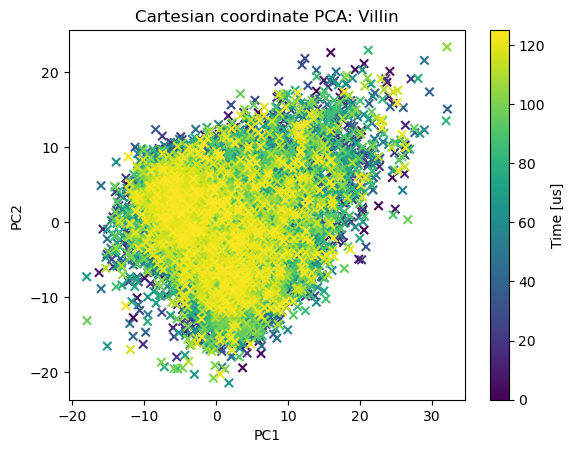

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

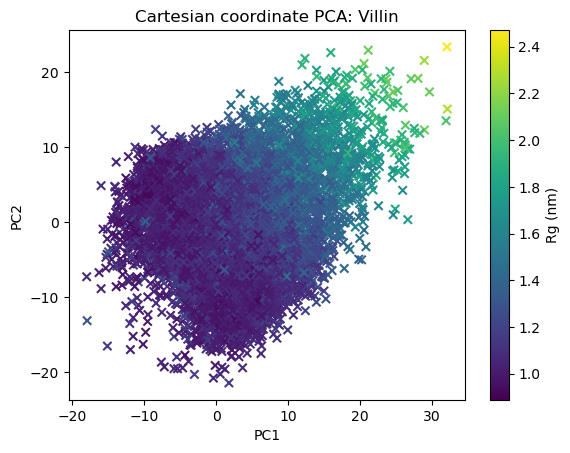

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

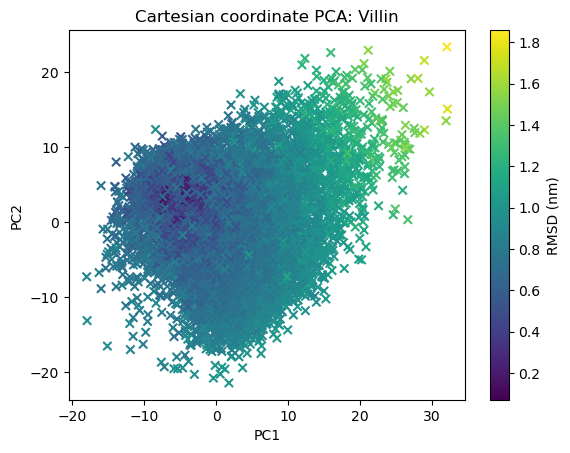

In [25]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

In [26]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [27]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



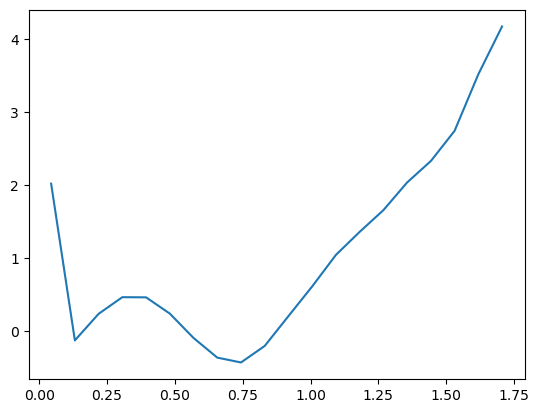

In [28]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

In [29]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')
plot_phipsi_FES_frames(45, basin_frames)

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

In [30]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

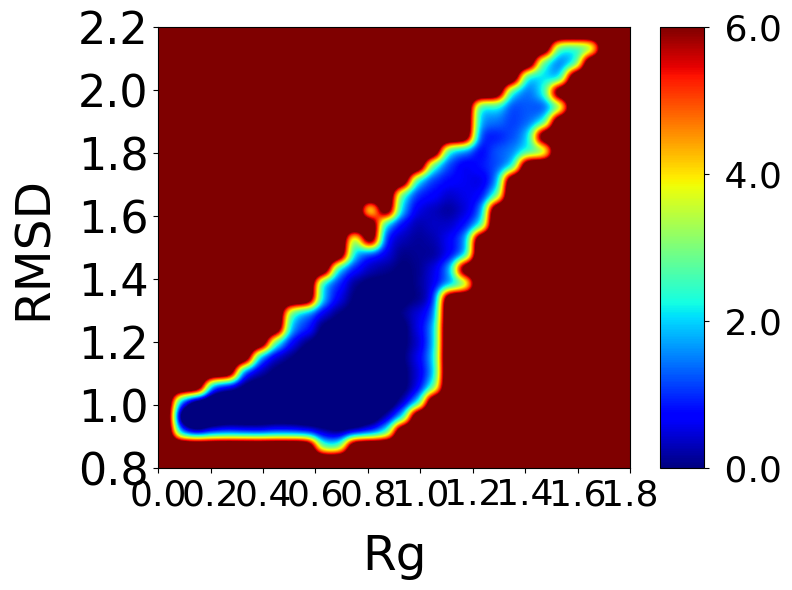

In [31]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [32]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [33]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

In [34]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

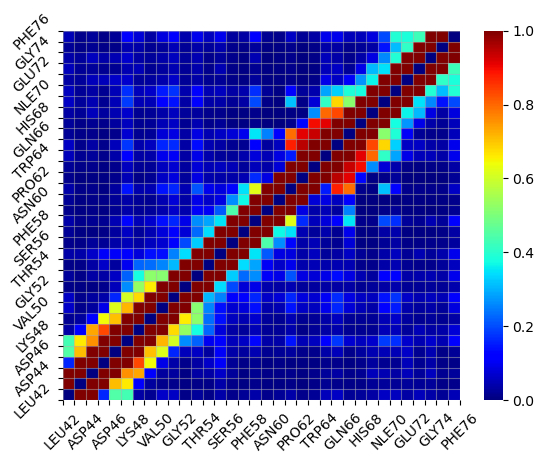

In [35]:
#Lets Make a Contact Map of the low dG Basin 
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[basin_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [36]:
#Lets Make a Contact Map of the native frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[native_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [37]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [38]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [39]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

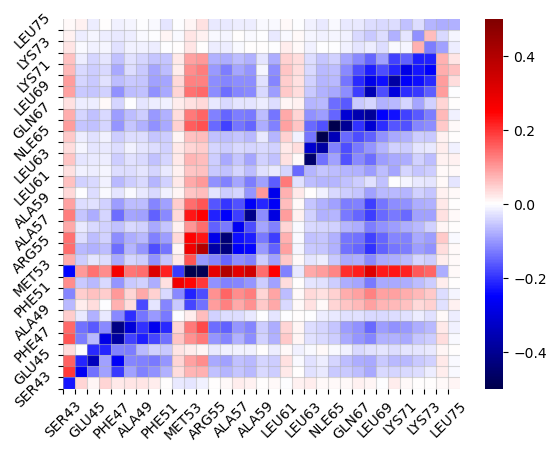

In [40]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

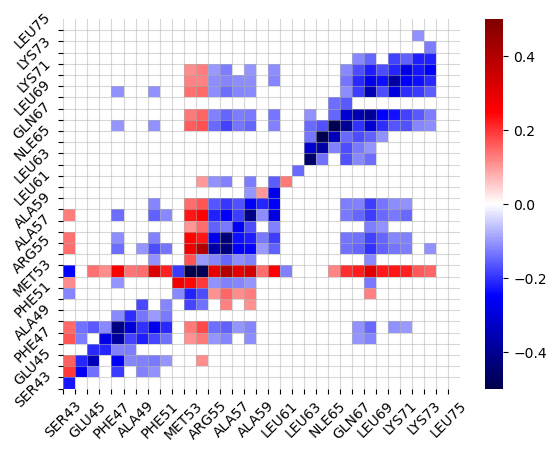

In [41]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

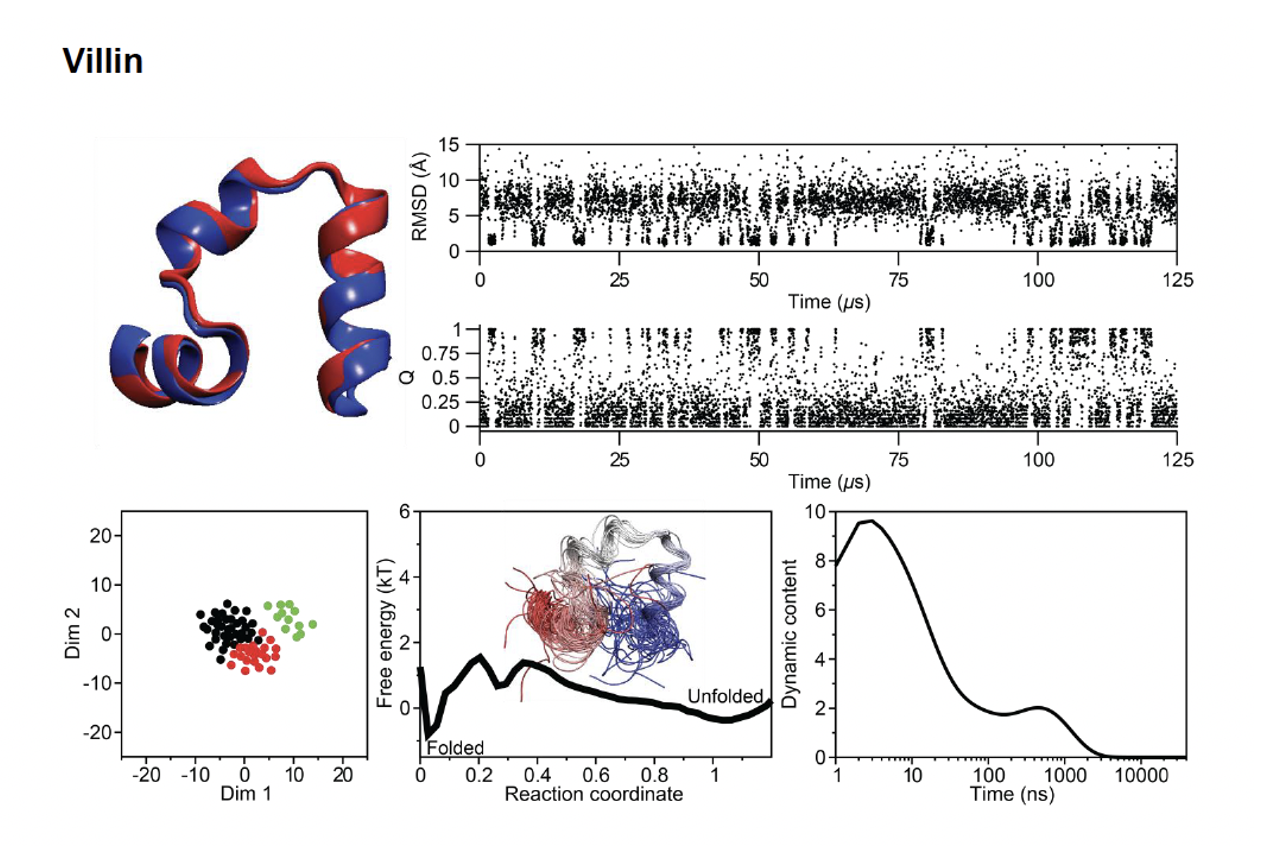

First we need to determine the native contacts and calculate Q

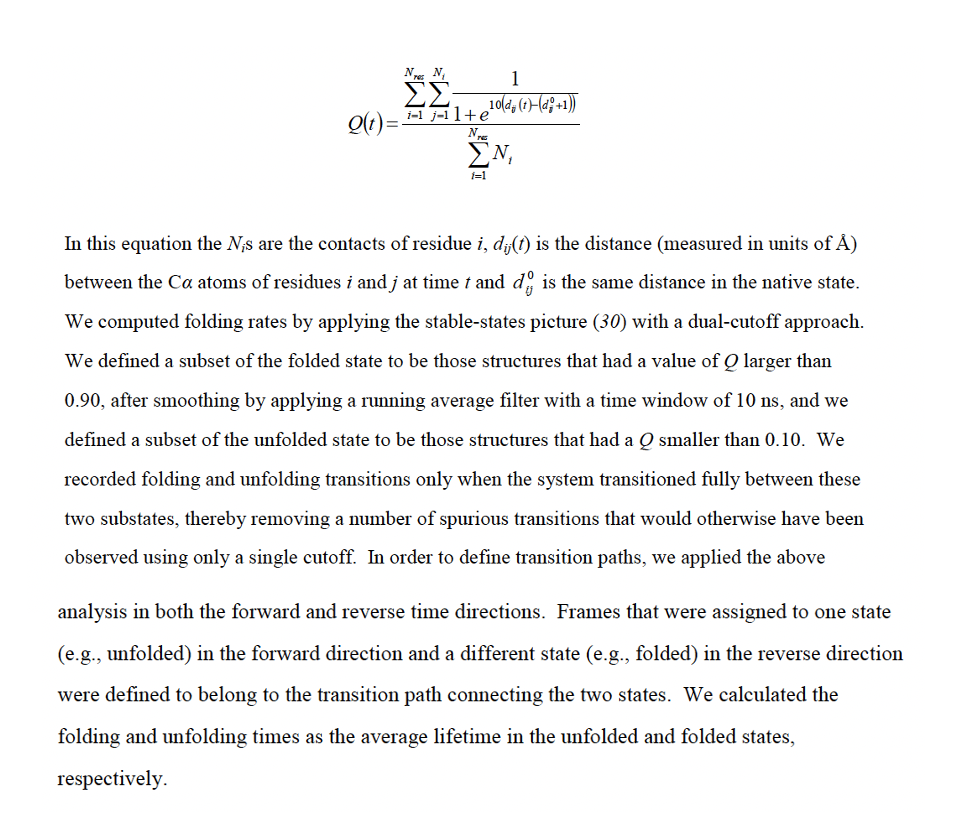

In [42]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x2c36fb0a610>

native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10

Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]

np.shape(Traj_Native_Contact_Distances)
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i])
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
 Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

#dirty
np.shape(Native_Contact_Distances)
#dirty
for i in range(0,46):
    print(Native_Contacts_Xray_Dist[i],Native_Contacts_Trj_Dist[i])
#dirty
Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
Xray_Distance_Expand
#dirty
Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

In [43]:
#Now Lets Consider a "Native Portion of the Trajectory"
#Define Native Frames
native_frames

array([  158,   159,   160, ..., 12022, 12023, 12027], dtype=int64)

In [44]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10

In [45]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

In [46]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 2054)

In [47]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 521, 550,
       557, 569, 570, 635, 636, 684, 701], dtype=int64)

In [48]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)


(46, 12559)

In [49]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
10.452459 [ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
10.225195 [14.985344 15.004972 16.675589 ...  8.071144  9.364284  8.658443]
6.8318415 [12.484558  12.280922  14.192814  ...  5.4976153  6.584661

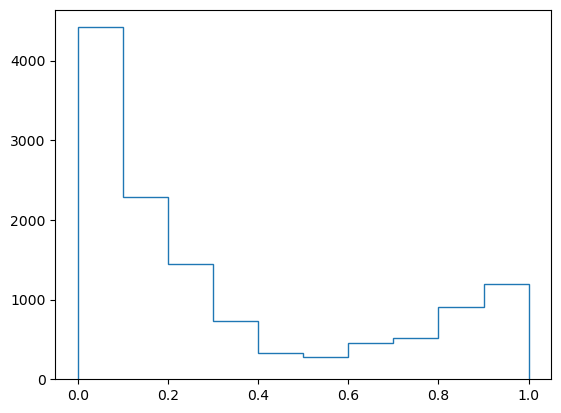

In [50]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

In [51]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [52]:
np.shape(traj_CA_distance_matrix1D)

(702, 12559)

In [53]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 521, 550,
       557, 569, 570, 635, 636, 684, 701], dtype=int64)

In [54]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distances=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distances))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(46, 12559)

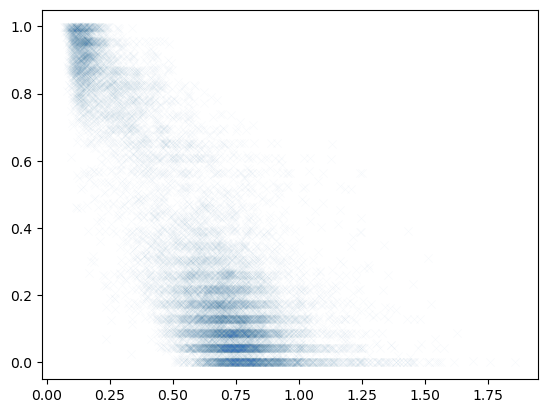

In [55]:
#Plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)

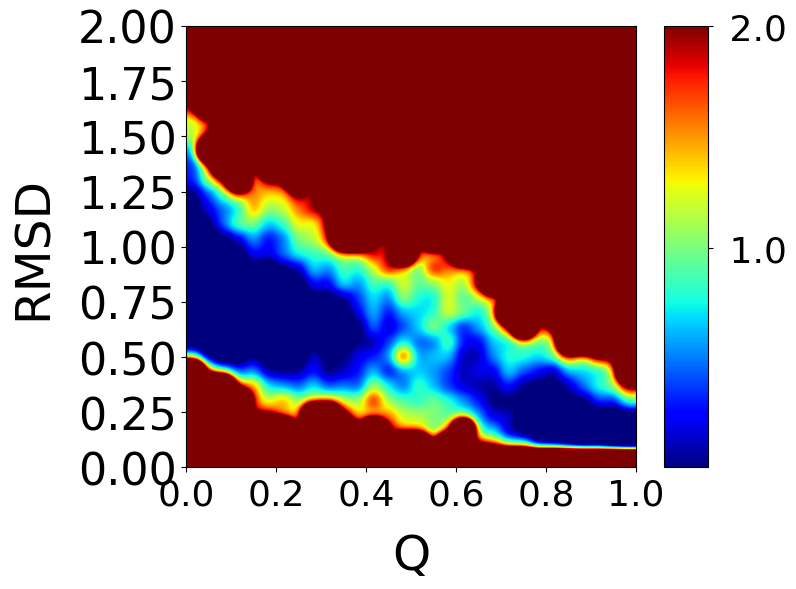

In [56]:
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

Text(0, 0.5, '$\\Delta$G')

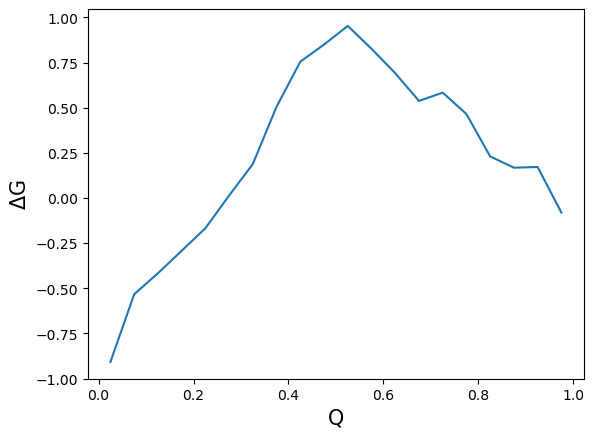

In [57]:
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

In [58]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

In [59]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames

#Select Only the Frames with low RMSD from native state for the native distances


#Filter the native distances to only include distances where the average value < 10A in the native frames 


#Check that we're comparing all the correct distances 


#Plot Q using only our native frames


#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 

#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations


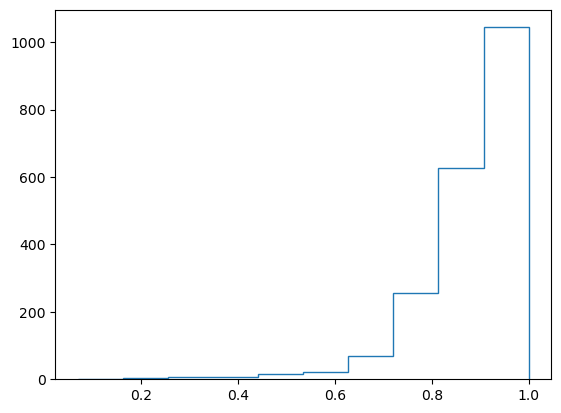

In [60]:
#Q1 Filtered Distances based on only the "Native Portion of the Trajectory"
#select only the native frames from Traj_CA_Distnaces
Q=1/(1+np.exp(10*(Traj_CA_Distnaces[:,native_frames]-(Native_Contact_Distances_nframes[:,native_frames]+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

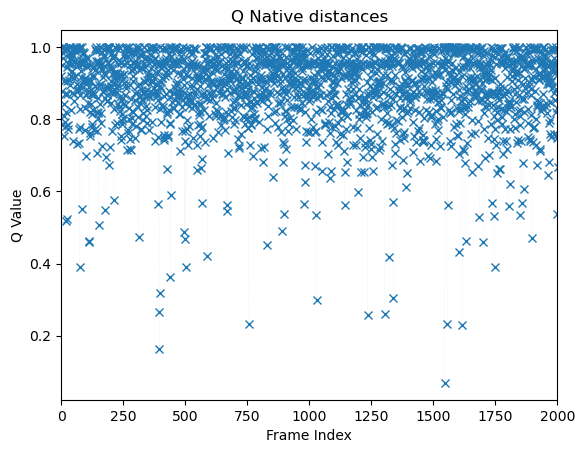

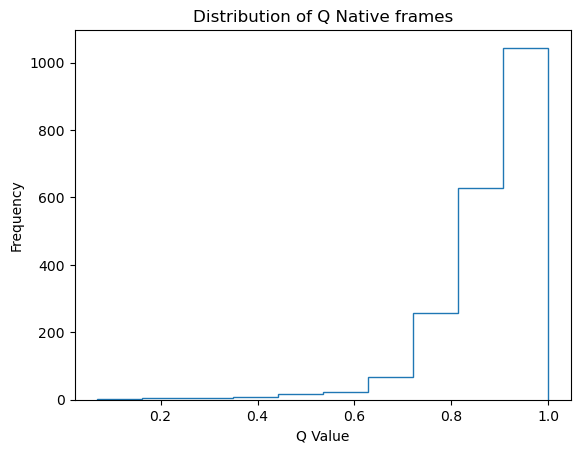

In [61]:
# recalculating the Q values
Q = 1 / (1 + np.exp(10 * (Traj_CA_Distnaces[:, native_frames] - (Native_Contact_Distances_nframes[:, native_frames] + 1))))
Q_sum = np.sum(Q, axis=0)
Q = Q_sum / len(Native_CA_Distances)

# Plot Q values
plt.plot(Q, marker='x', linewidth=0.01)
plt.xlabel('Frame Index')  # Adding label for x-axis
plt.ylabel('Q Value')  # Adding label for y-axis
plt.title('Q Native distances')  # Adding plot title
plt.xlim(0, 2000)
plt.show()
plt.clf()

# Plot histogram of Q values
plt.hist(Q, histtype='step')
plt.xlabel('Q Value')  # Adding label for x-axis
plt.ylabel('Frequency')  # Adding label for y-axis
plt.title('Distribution of Q Native frames')  # Adding plot title
plt.show()


Indices of filtered native distances: [ 0  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 23 24 25 26
 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Filtered native distances shape: (42, 12559)


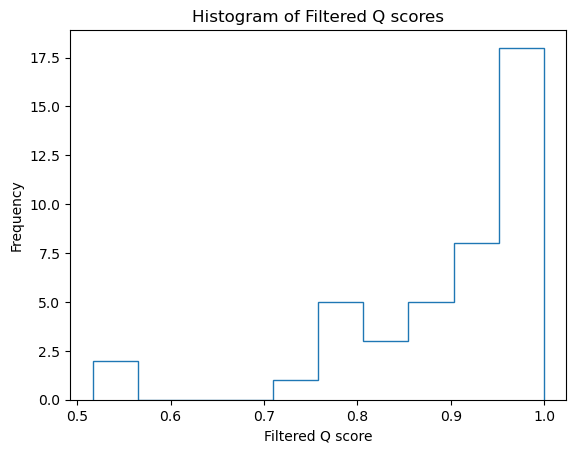

In [63]:
# Calculate the average distances in the native frames
average_native_distances = np.mean(Native_Contact_Distances_nframes[:, native_frames], axis=1)

# Filter distances with average value less than 10 Å
distance_threshold = 10  # Ångström
filtered_indices = np.where(average_native_distances < distance_threshold)[0]
filtered_native_distances = Native_Contact_Distances_nframes[filtered_indices, :]

print("Indices of filtered native distances:", filtered_indices)
print("Filtered native distances shape:", filtered_native_distances.shape)

# Optionally, you can also filter the Q score based on these indices
filtered_Q = Q[filtered_indices]

# Plot filtered Q score
plt.plot(filtered_Q, marker='x', linewidth=.01)
plt.xlabel('Frame index')
plt.ylabel('Filtered Q score')
plt.title('Filtered Q score per frame')
plt.show()

plt.clf()

# Plot histogram of filtered Q score
plt.hist(filtered_Q, histtype='step')
plt.xlabel('Filtered Q score')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Q scores')
plt.show()

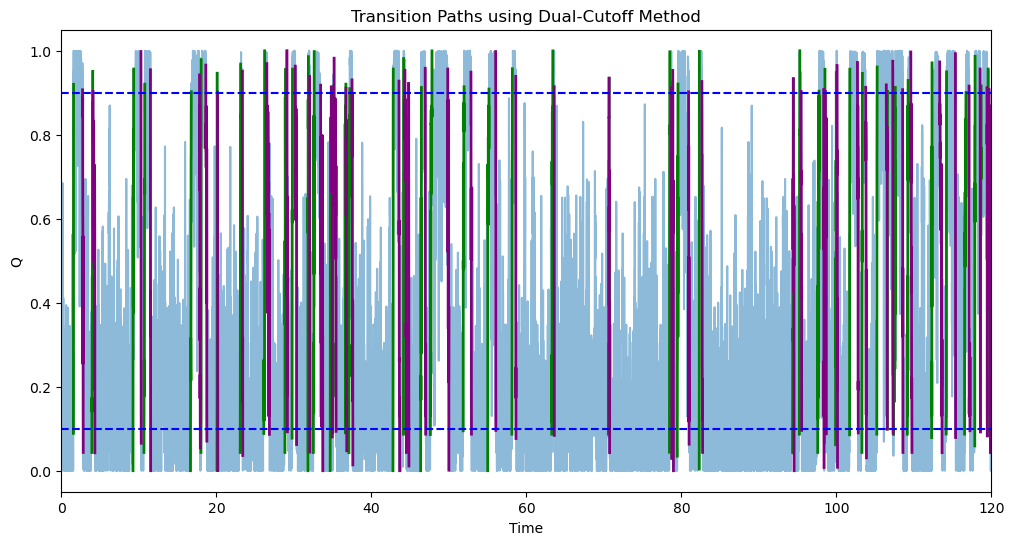

In [81]:
time=np.linspace(0,125,n_frames)
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)

# Organize Q values
Q_add_m1s = np.where(Q < 0.10, -1, Q)
Q_add_1s = np.where(Q_add_m1s > 0.90, 1, Q_add_m1s)
Q_add_0s = np.where((Q_add_1s != 1) & (Q_add_1s != -1), 0, Q_add_1s)

# Define cutoff thresholds
folded_threshold = 0.9
unfolded_threshold = 0.1

# Identify folding and unfolding paths
folding_paths = []
unfolding_paths = []
in_transition = False
start_index = None
for i in range(1, len(Q_add_0s)):
    if Q_add_0s[i-1] == -1 and Q_add_0s[i] == 0:
        in_transition = True
        start_index = i-1
    elif in_transition and Q_add_0s[i] == 1:
        if Q_add_0s[start_index:i].tolist().count(1) == 0:
            end_index = i
            folding_paths.append((time[start_index], time[end_index]))
        in_transition = False
    elif Q_add_0s[i-1] == 1 and Q_add_0s[i] == 0:
        in_transition = True
        start_index = i-1
    elif in_transition and Q_add_0s[i] == -1:
        if Q_add_0s[start_index:i].tolist().count(-1) == 0:
            end_index = i
            unfolding_paths.append((time[start_index], time[end_index]))
        in_transition = False

# Plot the transition paths
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)

# Highlight folding paths
for start, end in folding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='green', linewidth=2, label='Folding Path')

# Highlight unfolding paths
for start, end in unfolding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='purple', linewidth=2, label='Unfolding Path')

# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='blue', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='blue', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.ylabel('Q')
plt.xlim(0,120)
plt.title('Transition Paths using Dual-Cutoff Method')
plt.show()


In [65]:
#Print folding and unfolding paths
print("Folding Paths:", folding_paths)
print("Unfolding Paths:", unfolding_paths)

Folding Paths: [(1.5428412167542602, 1.5727026596591813), (3.931756649147953, 4.041248606465998), (9.23713967192228, 9.326724000637043), (10.650581302755215, 10.76007326007326), (16.652731326644368, 16.762223283962413), (18.006450071667462, 18.036311514572382), (20.076843446408663, 20.096751075011944), (23.07294155120242, 23.132664437012263), (26.11880872750438, 26.228300684822422), (28.836200031852204, 28.915830546265326), (29.76190476190476, 29.821627647714603), (31.80243669374104, 31.872113393852523), (32.499203694855865, 32.61864946647555), (34.679089026915115, 34.82839624143972), (35.01751871317089, 35.07724159898073), (36.63999044433827, 36.70966714444975), (37.09786590221373, 37.19740404523013), (42.78149386845039, 42.82130912565695), (44.13521261347348, 44.15512024207676), (44.76230291447683, 44.80211817168339), (46.35491320273929, 46.45445134575569), (47.599139990444336, 47.81812390508043), (51.83946488294314, 51.95891065456283), (55.00477783086478, 55.17399267399267), (58.130

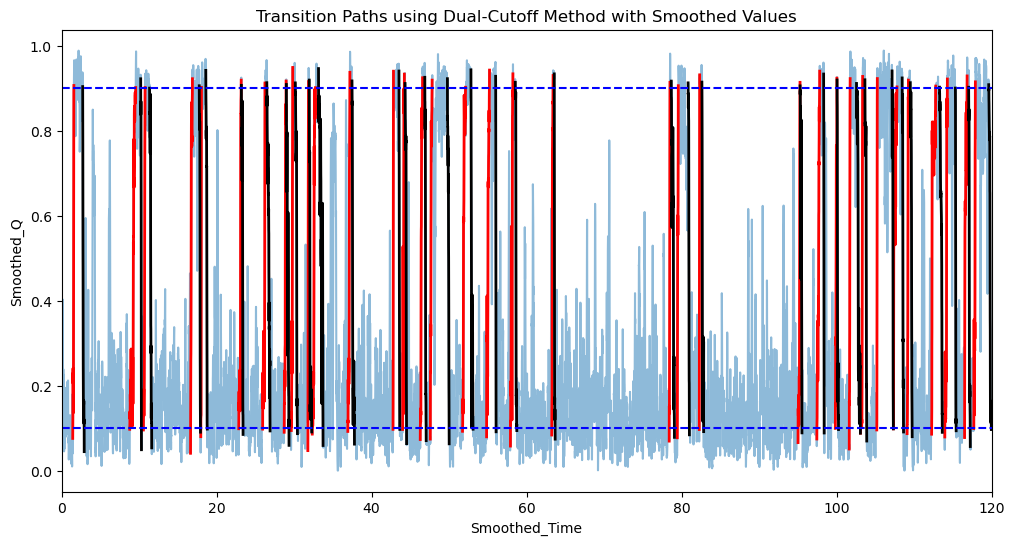

In [82]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations

# Define smoothing window size
window_size = 5

# Smooth Q values
smoothed_Q = np.convolve(Q, np.ones(window_size)/window_size, mode='valid')

# Smooth time values
smoothed_time = np.convolve(time, np.ones(window_size)/window_size, mode='valid')

# Identify folding and unfolding paths using smoothed Q values
smoothed_folding_paths = []
smoothed_unfolding_paths = []
in_transition = False
start_index = None
for i in range(1, len(smoothed_Q)):
    if smoothed_Q[i-1] < unfolded_threshold and smoothed_Q[i] >= unfolded_threshold:
        in_transition = True
        start_index = i-1
    elif in_transition and smoothed_Q[i] >= folded_threshold:
        if np.all(smoothed_Q[start_index:i] < folded_threshold):
            end_index = i
            smoothed_folding_paths.append((smoothed_time[start_index], smoothed_time[end_index]))
        in_transition = False
    elif smoothed_Q[i-1] > folded_threshold and smoothed_Q[i] <= folded_threshold:
        in_transition = True
        start_index = i-1
    elif in_transition and smoothed_Q[i] <= unfolded_threshold:
        if np.all(smoothed_Q[start_index:i] > unfolded_threshold):
            end_index = i
            smoothed_unfolding_paths.append((smoothed_time[start_index], smoothed_time[end_index]))
        in_transition = False

# Plot the transition paths with smoothed values
plt.figure(figsize=(12, 6))
plt.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)

# Highlight folding paths
for start, end in smoothed_folding_paths:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='red', linewidth=2, label='Folding Path')

# Highlight unfolding paths
for start, end in smoothed_unfolding_paths:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='black', linewidth=2, label='Unfolding Path')

# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='b', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')

# Customize the plot
plt.xlabel('Smoothed_Time')
plt.ylabel('Smoothed_Q')
plt.xlim(0,120)
plt.title('Transition Paths using Dual-Cutoff Method with Smoothed Values')
plt.show()

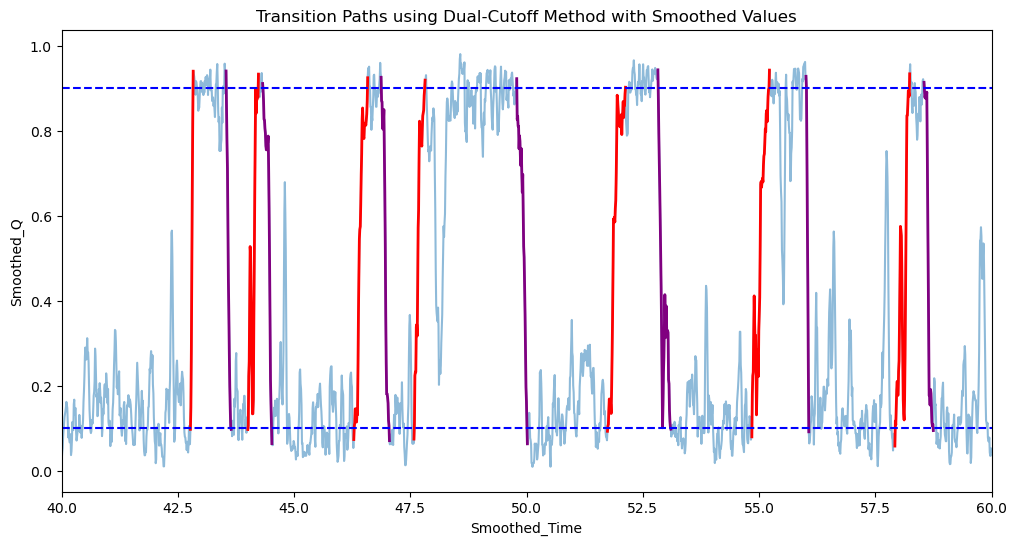

In [83]:
#zoomed in on some transition paths

#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations

# Define smoothing window size
window_size = 5

# Smooth Q values
smoothed_Q = np.convolve(Q, np.ones(window_size)/window_size, mode='valid')

# Smooth time values
smoothed_time = np.convolve(time, np.ones(window_size)/window_size, mode='valid')

# Identify folding and unfolding paths using smoothed Q values
smoothed_folding_paths = []
smoothed_unfolding_paths = []
in_transition = False
start_index = None
for i in range(1, len(smoothed_Q)):
    if smoothed_Q[i-1] < unfolded_threshold and smoothed_Q[i] >= unfolded_threshold:
        in_transition = True
        start_index = i-1
    elif in_transition and smoothed_Q[i] >= folded_threshold:
        if np.all(smoothed_Q[start_index:i] < folded_threshold):
            end_index = i
            smoothed_folding_paths.append((smoothed_time[start_index], smoothed_time[end_index]))
        in_transition = False
    elif smoothed_Q[i-1] > folded_threshold and smoothed_Q[i] <= folded_threshold:
        in_transition = True
        start_index = i-1
    elif in_transition and smoothed_Q[i] <= unfolded_threshold:
        if np.all(smoothed_Q[start_index:i] > unfolded_threshold):
            end_index = i
            smoothed_unfolding_paths.append((smoothed_time[start_index], smoothed_time[end_index]))
        in_transition = False

# Plot the transition paths with smoothed values
plt.figure(figsize=(12, 6))
plt.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)

# Highlight folding paths
for start, end in smoothed_folding_paths:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='red', linewidth=2, label='Folding Path')

# Highlight unfolding paths
for start, end in smoothed_unfolding_paths:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='purple', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='blue', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='blue', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Smoothed_Time')
plt.ylabel('Smoothed_Q')
plt.xlim(40,60)
plt.title('Transition Paths using Dual-Cutoff Method with Smoothed Values')
plt.show()

In [68]:
#showing some long folding paths and some short folding paths
# Define thresholds for path duration
short_path_threshold = .2
long_path_threshold = .5
# Initialize lists to store longer and shorter paths
long_folding_paths = []
short_folding_paths = []
long_unfolding_paths = []
short_unfolding_paths = []
# Iterate through folding paths to categorize them as long or short
for start, end in smoothed_folding_paths:
    path_duration = end - start
    if path_duration > long_path_threshold:
        long_folding_paths.append((start, end))
    else:
        short_folding_paths.append((start, end))
# Iterate through unfolding paths to categorize them as long or short
for start, end in smoothed_unfolding_paths:
    path_duration = end - start
    if path_duration > long_path_threshold:
        long_unfolding_paths.append((start, end))
    else:
        short_unfolding_paths.append((start, end))
# Print or use the categorized paths as needed
print("Long Folding Paths:", long_folding_paths)
print("Short Folding Paths:", short_folding_paths)
print("Long Unfolding Paths:", long_unfolding_paths)
print("Short Unfolding Paths:", short_unfolding_paths)

Long Folding Paths: [(8.799171842650104, 9.565615543876413), (112.26907150820196, 112.79662366618888)]
Short Folding Paths: [(1.4433030737378565, 1.5926102882624622), (10.560996974040451, 10.77998088867654), (16.642777512342732, 16.89162286988374), (17.9666348144609, 18.056219143175664), (22.86391145086797, 23.182433508520468), (25.94959388437649, 26.248208313425703), (28.726708074534162, 28.97555343207517), (29.642458990285075, 29.831581462016246), (31.78252906513776, 31.872113393852523), (32.34989648033126, 32.76795668100016), (36.93860487338748, 37.207357859531776), (42.77154005414875, 42.83126293995859), (44.00581302755216, 44.23475075648989), (46.285236502627804, 46.58385093167702), (47.57923236184105, 47.81812390508043), (51.73992673992674, 52.12812549769071), (54.84551680203854, 55.22376174550088), (57.921245421245416, 58.23976747889791), (63.24653607262303, 63.42570473005255), (78.40619525402134, 78.50573339703774), (79.45134575569358, 79.58074534161491), (82.28818283166109, 82

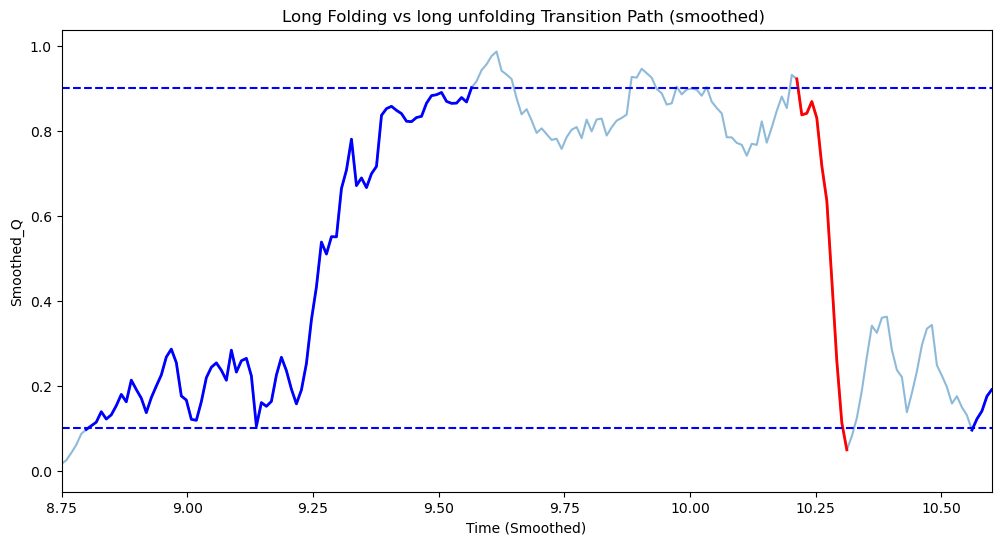

In [84]:
#A Plot of long transition paths
plt.figure(figsize=(12, 6))
plt.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)

# Highlight folding paths
for start, end in smoothed_folding_paths:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='blue', linewidth=2, label='Folding Path')

# Highlight unfolding paths
for start, end in smoothed_unfolding_paths:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='red', linewidth=2, label='Unfolding Path')

# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='b', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')

# Customize the plot
plt.xlabel('Time (Smoothed)')

#adjusting x limit to show path of interest
plt.xlim(8.75,10.6)
plt.ylabel('Smoothed_Q')
plt.title('Long Folding vs long unfolding Transition Path (smoothed) ')
plt.show()

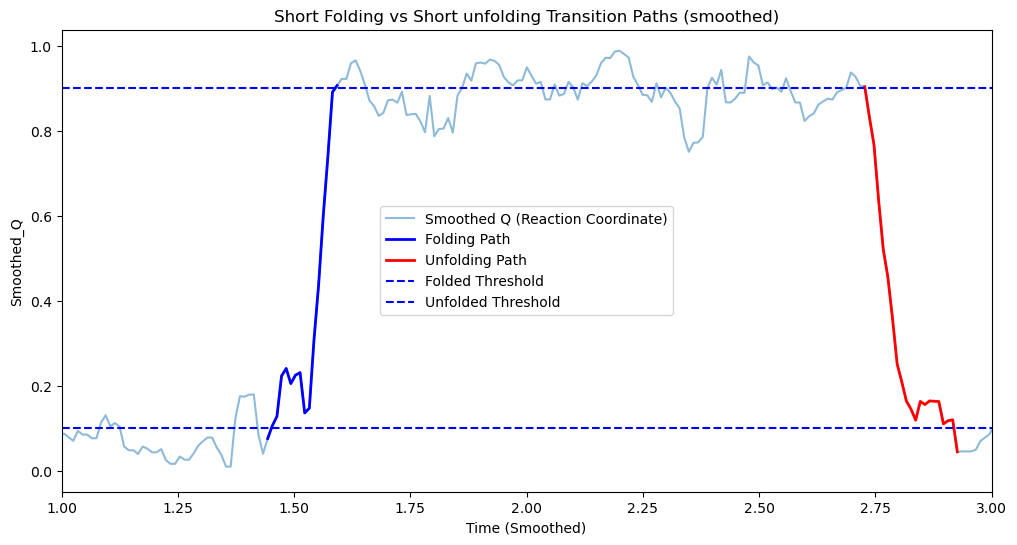

In [85]:
#A Plot of long transition paths
plt.figure(figsize=(12, 6))
plt.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for i, (start, end) in enumerate(smoothed_folding_paths):
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='blue', linewidth=2, label='Folding Path' if i == 0 else "")

# Highlight unfolding paths
for i, (start, end) in enumerate(smoothed_unfolding_paths):
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='red', linewidth=2, label='Unfolding Path' if i == 0 else "")
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='b', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time (Smoothed)')
#adjusting x limit to show path of interest
plt.xlim(1, 3)
plt.ylabel('Smoothed_Q')
plt.title('Short Folding vs Short unfolding Transition Paths (smoothed)')
plt.legend()
plt.show()

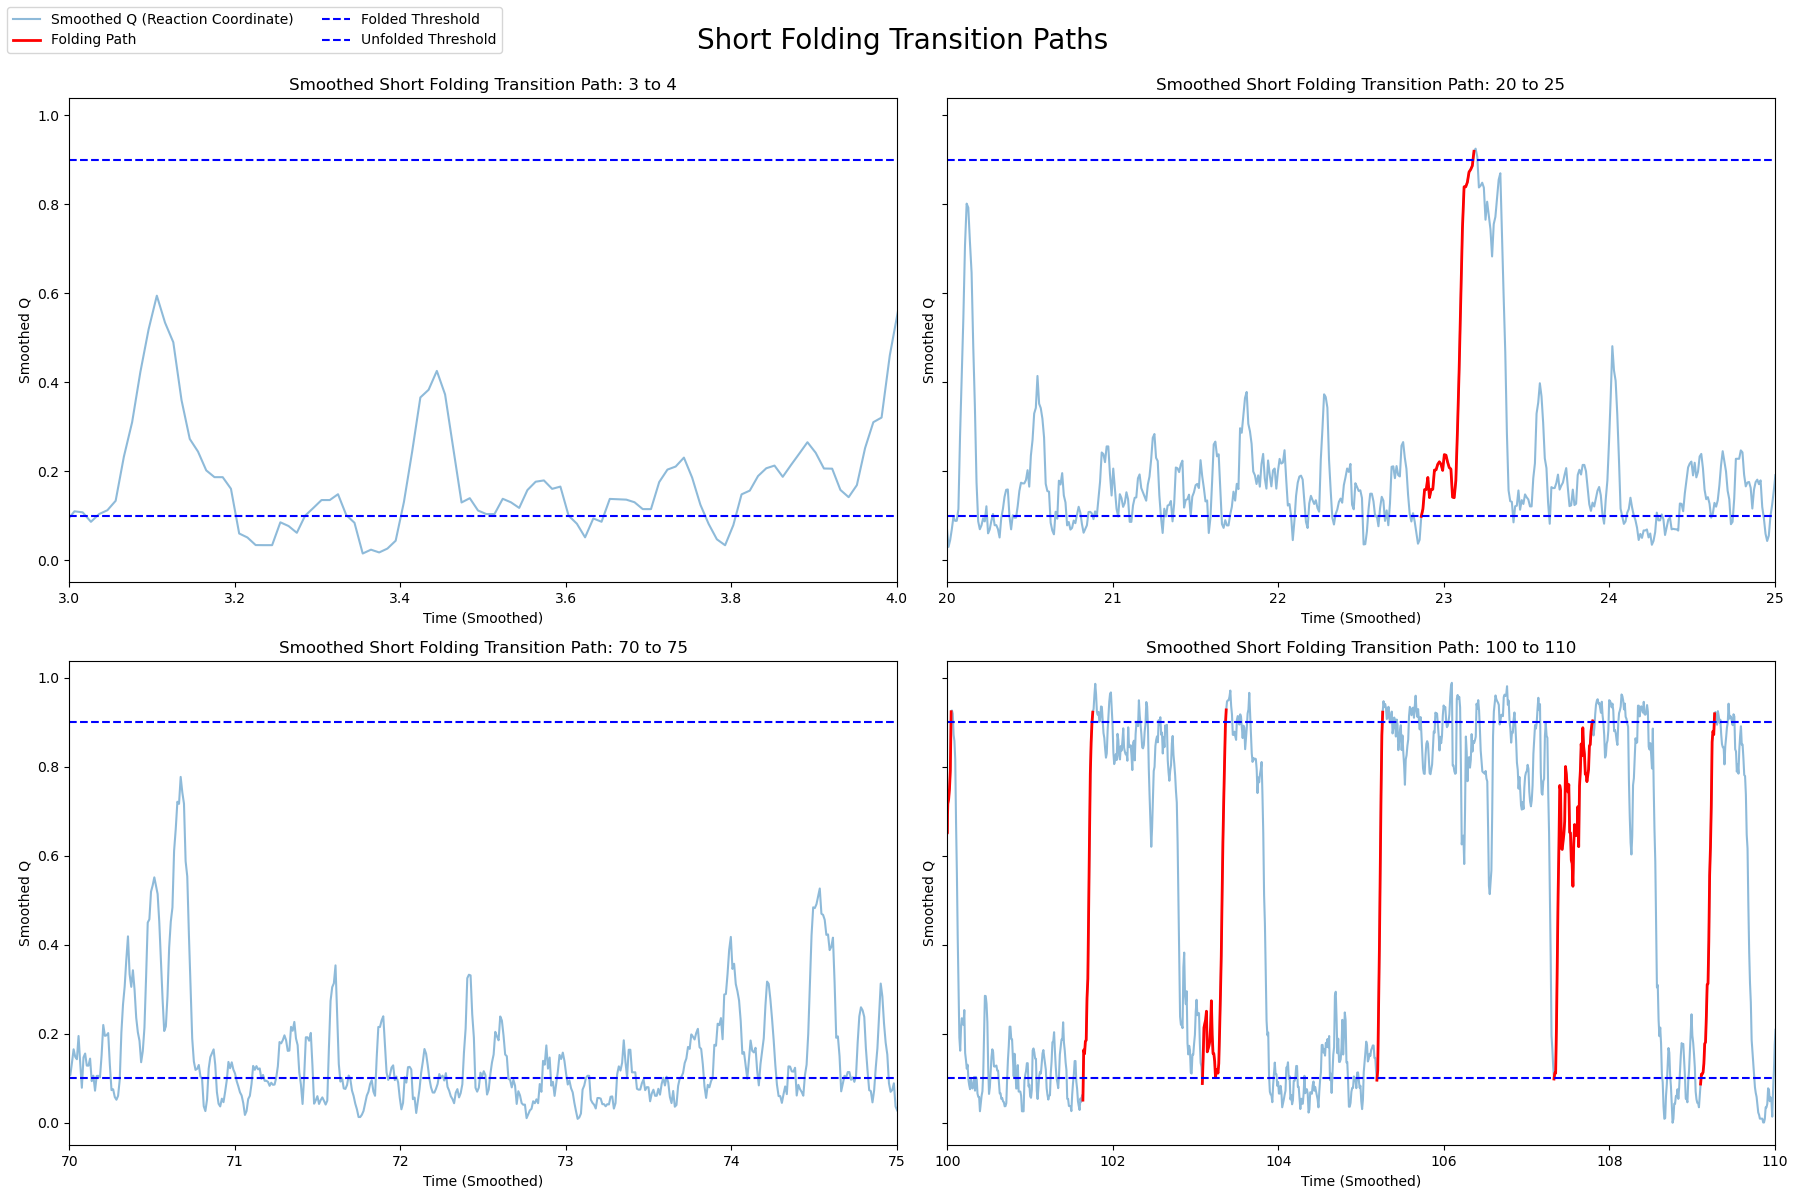

In [88]:
import matplotlib.pyplot as plt

# Assuming smoothed_time, smoothed_Q, folding_paths_smoothed, unfolded_paths_smoothed, 
# folded_threshold, and unfolded_threshold are defined

# Define the time ranges for the different short folding transition paths
time_ranges = [(3, 4), (20, 25), (70, 75), (100, 110)]

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each time range in a different subplot
for ax, (start_time, end_time) in zip(axes, time_ranges):
    # Plot the smoothed Q data
    ax.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)
    
    # Highlight folding paths
    for i, (start, end) in enumerate(smoothed_folding_paths):
        ax.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
                smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
                color='red', linewidth=2, label='Folding Path' if i == 0 else "")
    
    # Mark thresholds for folded and unfolded states
    ax.axhline(folded_threshold, color='blue', linestyle='--', label='Folded Threshold')
    ax.axhline(unfolded_threshold, color='blue', linestyle='--', label='Unfolded Threshold')
    
    # Customize the plot
    ax.set_xlim(start_time, end_time)
    ax.set_xlabel('Time (Smoothed)')
    ax.set_ylabel('Smoothed Q')
    ax.set_title(f'Smoothed Short Folding Transition Path: {start_time} to {end_time}')

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Short Folding Transition Paths', y=0.98, fontsize=20)
plt.show()


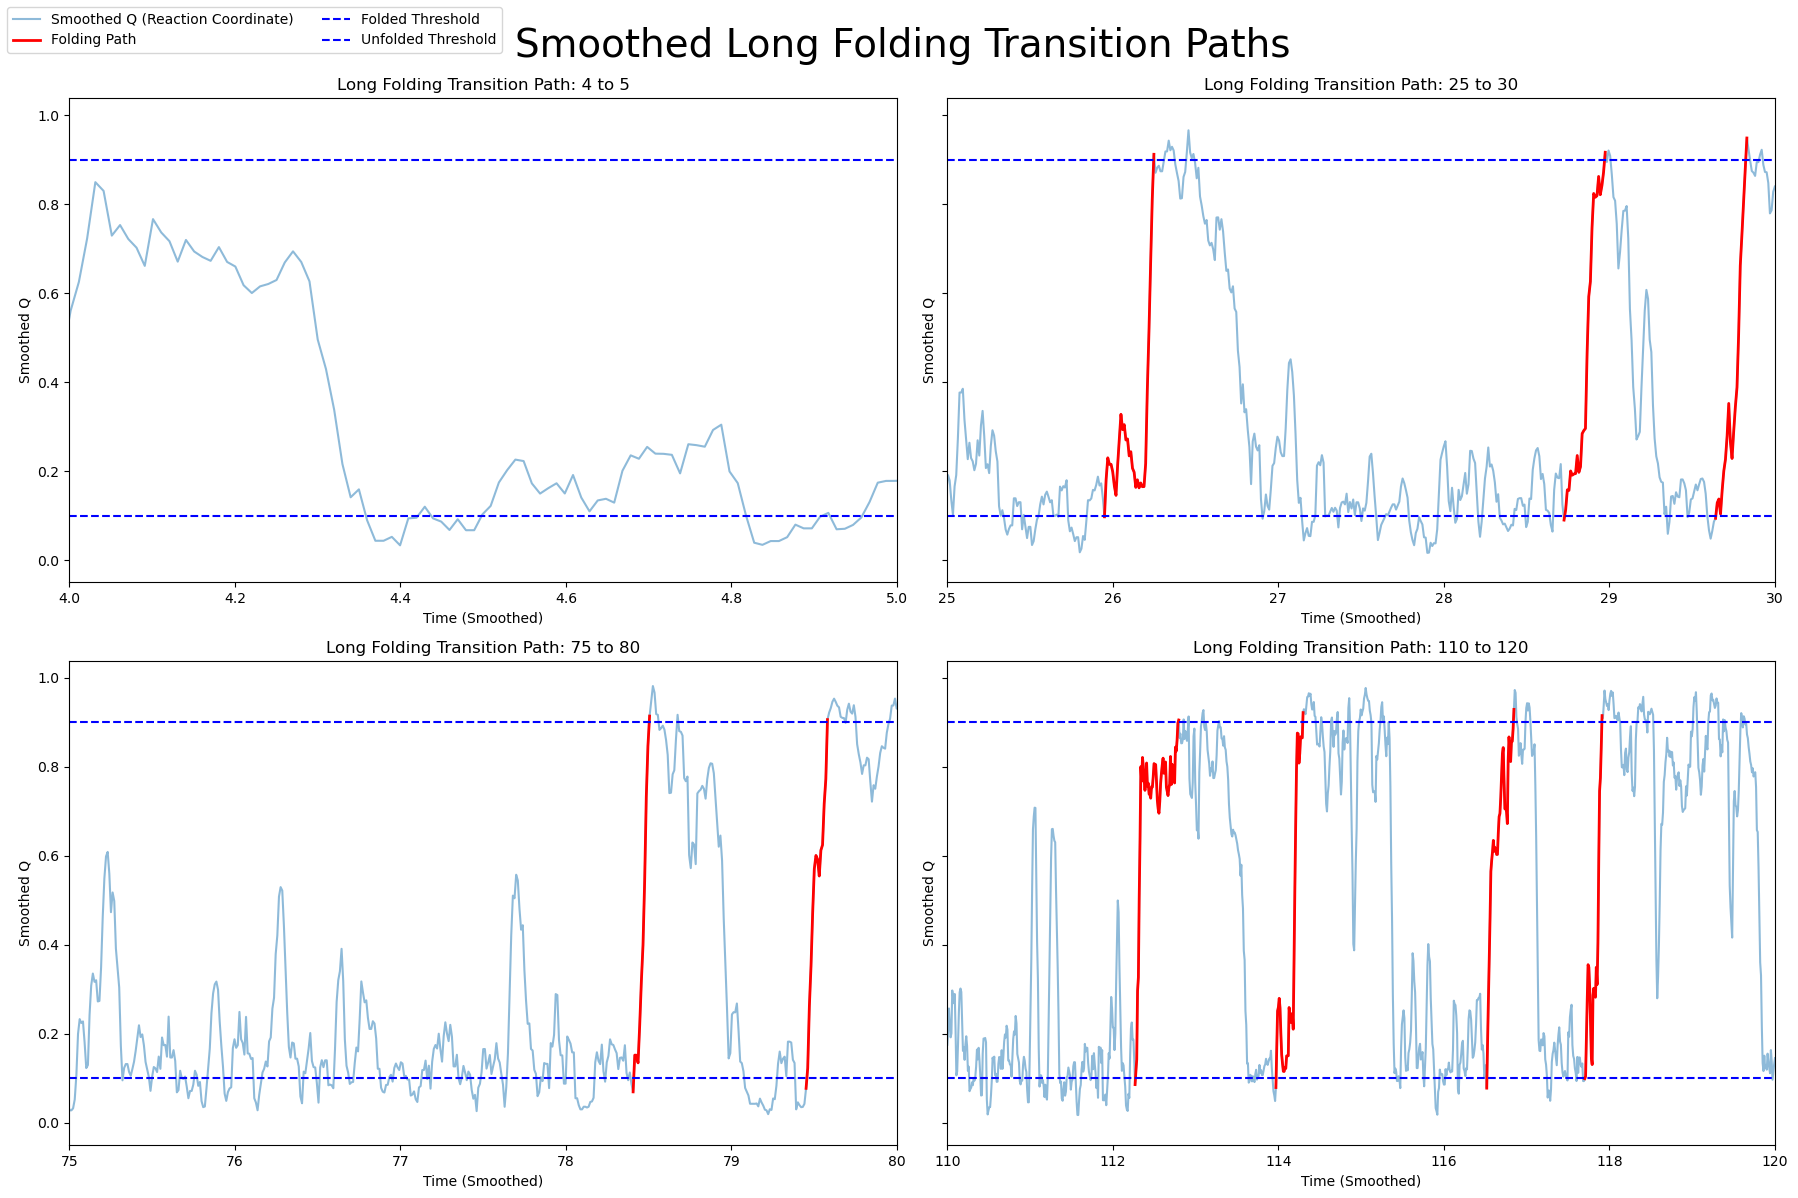

In [91]:
#plots of some long folding transition paths
# Assuming smoothed_time, smoothed_Q, folding_paths_smoothed, unfolded_paths_smoothed, 
# folded_threshold, and unfolded_threshold are defined

# Define the time ranges for the different short folding transition paths
time_ranges = [(4, 5), (25, 30), (75, 80), (110, 120)]

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each time range in a different subplot
for ax, (start_time, end_time) in zip(axes, time_ranges):
    # Plot the smoothed Q data
    ax.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)
    
    # Highlight folding paths
    for i, (start, end) in enumerate(smoothed_folding_paths):
        ax.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
                smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
                color='red', linewidth=2, label='Folding Path' if i == 0 else "")
    
    # Mark thresholds for folded and unfolded states
    ax.axhline(folded_threshold, color='blue', linestyle='--', label='Folded Threshold')
    ax.axhline(unfolded_threshold, color='blue', linestyle='--', label='Unfolded Threshold')
    
    # Customize the plot
    ax.set_xlim(start_time, end_time)
    ax.set_xlabel('Time (Smoothed)')
    ax.set_ylabel('Smoothed Q')
    ax.set_title(f'Long Folding Transition Path: {start_time} to {end_time}')

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Smoothed Long Folding Transition Paths', y=0.98, fontsize=28)
plt.show()


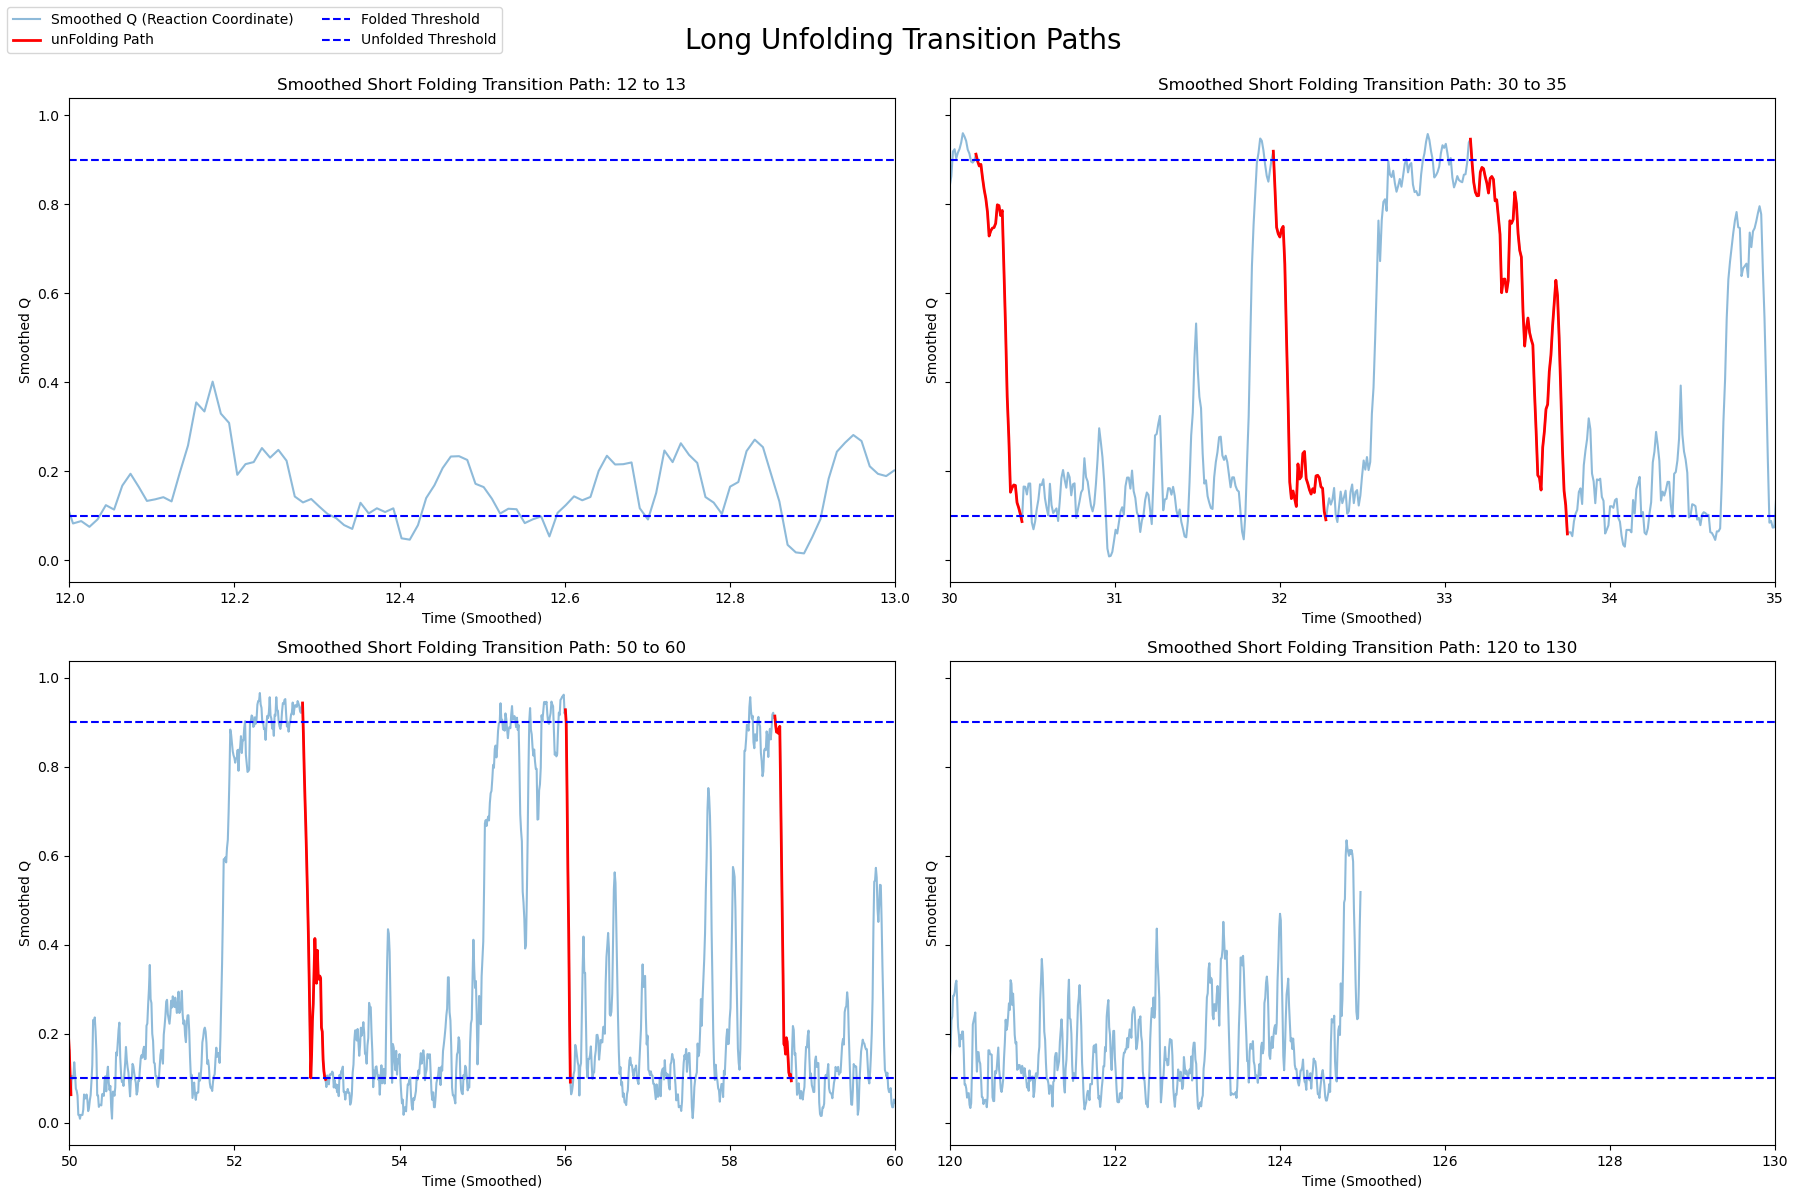

In [92]:
#some plots of Long unfolding transition paths
# Assuming smoothed_time, smoothed_Q, folding_paths_smoothed, unfolded_paths_smoothed, 
# folded_threshold, and unfolded_threshold are defined

# Define the time ranges for the different short folding transition paths
time_ranges = [(12, 13), (30, 35), (50, 60), (120, 130)]

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each time range in a different subplot
for ax, (start_time, end_time) in zip(axes, time_ranges):
    # Plot the smoothed Q data
    ax.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)
    
    # Highlight folding paths
    for i, (start, end) in enumerate(smoothed_unfolding_paths):
        ax.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
                smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
                color='red', linewidth=2, label='unFolding Path' if i == 0 else "")
    
    # Mark thresholds for folded and unfolded states
    ax.axhline(folded_threshold, color='blue', linestyle='--', label='Folded Threshold')
    ax.axhline(unfolded_threshold, color='blue', linestyle='--', label='Unfolded Threshold')
    
    # Customize the plot
    ax.set_xlim(start_time, end_time)
    ax.set_xlabel('Time (Smoothed)')
    ax.set_ylabel('Smoothed Q')
    ax.set_title(f'Smoothed Short Folding Transition Path: {start_time} to {end_time}')

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Long Unfolding Transition Paths', y=0.98, fontsize=20)
plt.show()


In [93]:
import matplotlib.pyplot as plt

# Assuming smoothed_time, smoothed_Q, folding_paths_smoothed, unfolded_paths_smoothed, 
# folded_threshold, and unfolded_threshold are defined

# Define the time ranges for the different short folding transition paths
time_ranges = [(3, 3.1), (40, 40.5), (60, 61), (112, 120)]

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each time range in a different subplot
for ax, (start_time, end_time) in zip(axes, time_ranges):
    # Plot the smoothed Q data
    ax.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)
    
    # Highlight folding paths
    for i, (start, end) in enumerate(smoothed_unfolding_paths):
        ax.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
                smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
                color='red', linewidth=2, label='Folding Path' if i == 0 else "")
    
    # Mark thresholds for folded and unfolded states
    ax.axhline(folded_threshold, color='blue', linestyle='--', label='Folded Threshold')
    ax.axhline(unfolded_threshold, color='blue', linestyle='--', label='Unfolded Threshold')
    
    # Customize the plot
    ax.set_xlim(start_time, end_time)
    ax.set_xlabel('Time (Smoothed)')
    ax.set_ylabel('Smoothed Q')
    ax.set_title(f'Smoothed Short Unfolding Transition Path: {start_time} to {end_time}')

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Short Folding Transition Paths', y=0.98, fontsize=20)
plt.show()


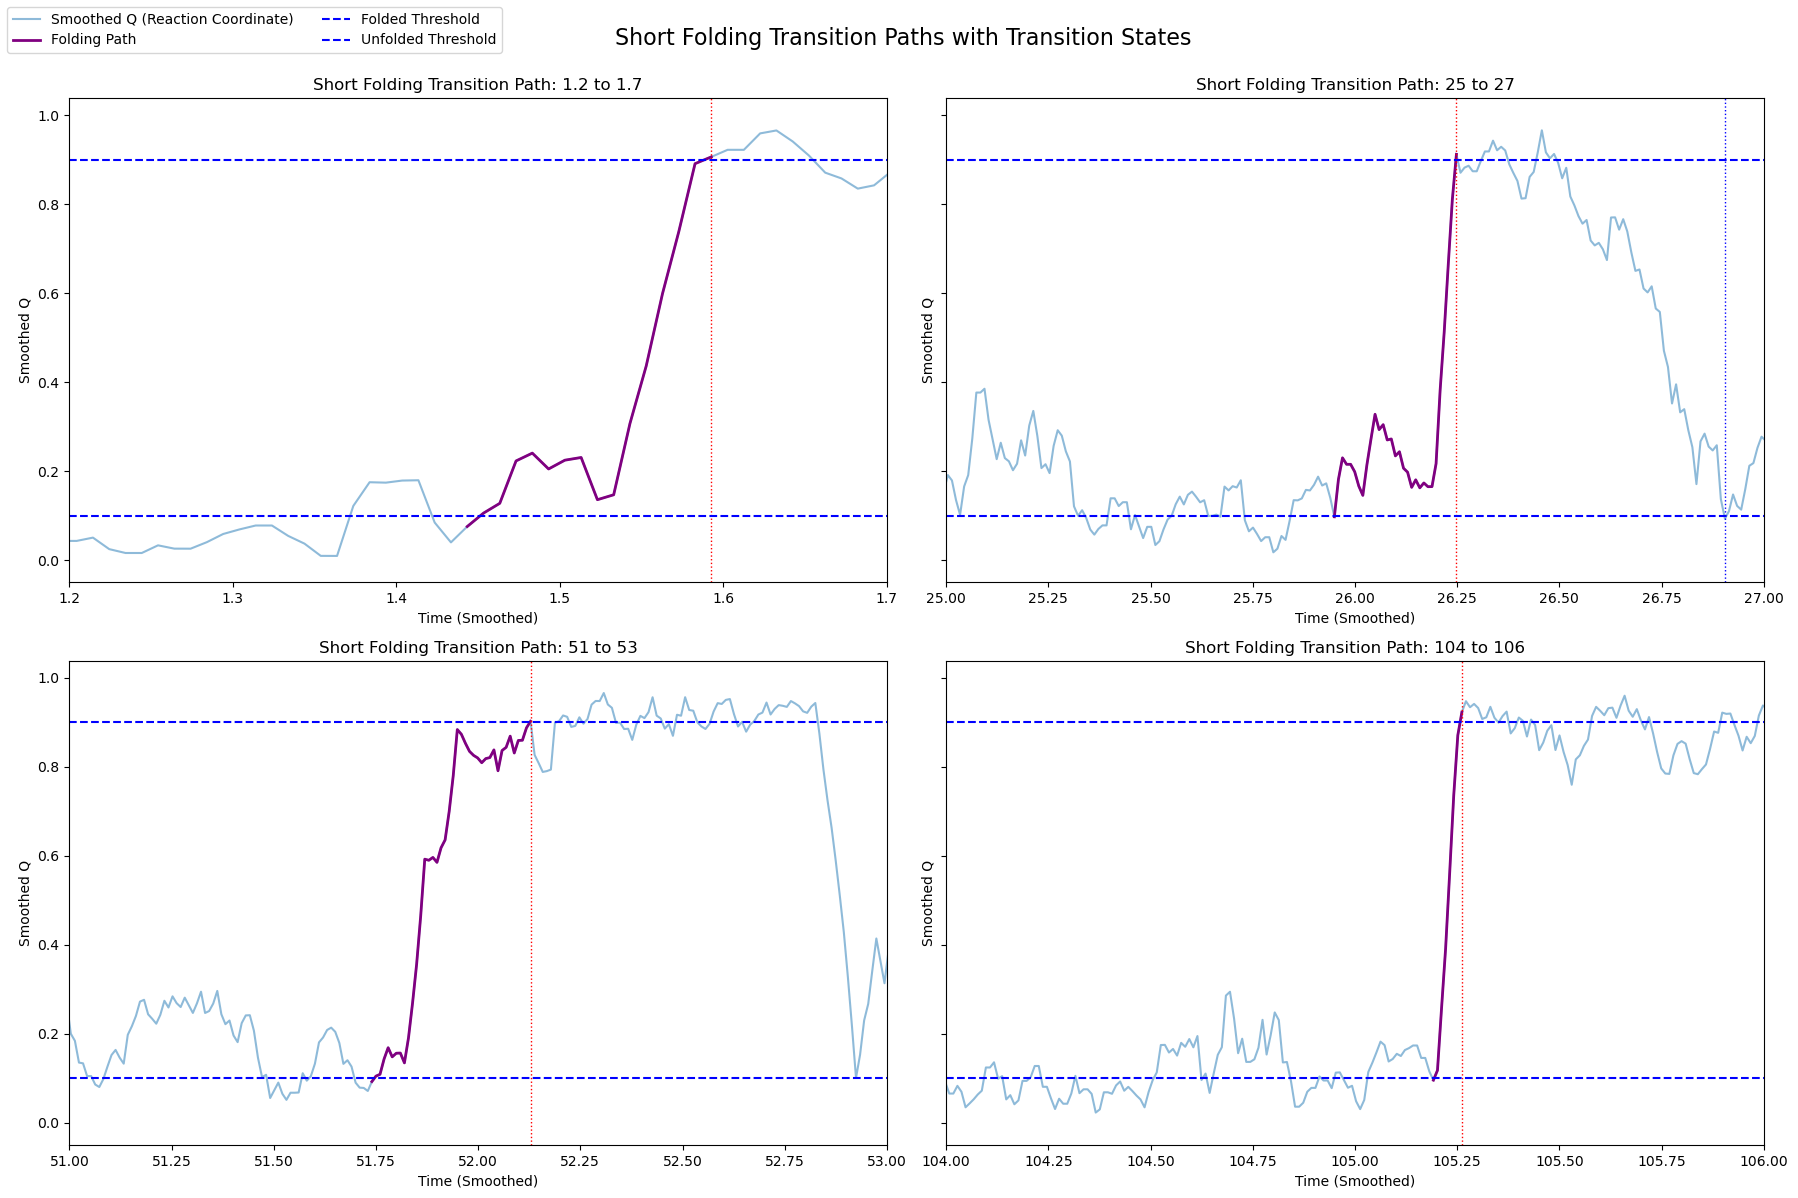

In [95]:

# Assuming smoothed_time, smoothed_Q, folded_threshold, and unfolded_threshold are defined

# Function to find transitions
def find_transitions(time, data, folded_threshold, unfolded_threshold):
    transitions = []
    state = None  # Current state: None, 'folded', or 'unfolded'

    for i in range(1, len(data)):
        if data[i-1] <= folded_threshold and data[i] > folded_threshold:
            if state != 'folded':
                transitions.append((time[i], 'folded'))
                state = 'folded'
        elif data[i-1] >= unfolded_threshold and data[i] < unfolded_threshold:
            if state != 'unfolded':
                transitions.append((time[i], 'unfolded'))
                state = 'unfolded'
    
    return transitions

# Find transitions
transitions = find_transitions(smoothed_time, smoothed_Q, folded_threshold, unfolded_threshold)

# Define the time ranges for the different short folding transition paths
time_ranges = [(1.2, 1.7), (25, 27), (51, 53), (104, 106)]

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=False, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each time range in a different subplot
for ax, (start_time, end_time) in zip(axes, time_ranges):
    # Plot the smoothed Q data
    ax.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)
    
    # Highlight folding paths
    for i, (start, end) in enumerate(smoothed_folding_paths):
        ax.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
                smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
                color='purple', linewidth=2, label='Folding Path' if i == 0 else "")
    
    # Highlight transition points
    for t, state in transitions:
        if start_time <= t <= end_time:
            color = 'red' if state == 'folded' else 'blue'
            ax.axvline(x=t, color=color, linestyle=':', linewidth=1, label=f'Transition to {state}' if t == transitions[0][0] else "")
    
    # Mark thresholds for folded and unfolded states
    ax.axhline(folded_threshold, color='blue', linestyle='--', label='Folded Threshold')
    ax.axhline(unfolded_threshold, color='blue', linestyle='--', label='Unfolded Threshold')
    
    # Customize the plot
    ax.set_xlim(start_time, end_time)
    ax.set_xlabel('Time (Smoothed)')
    ax.set_ylabel('Smoothed Q')
    ax.set_title(f'Short Folding Transition Path: {start_time} to {end_time}')

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Short Folding Transition Paths with Transition States', y=0.98, fontsize=16)
plt.show()


In [76]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])